In [57]:
import tensorflow as tf
import numpy as np
import math
import timeit

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def show_images_mxn(images, m, n):
    #images = np.reshape(images, [m, n, -1])
    sqrtimg = int(np.ceil(np.sqrt(images.shape[2])))

    fig = plt.figure(figsize=(m, n))
    gs = gridspec.GridSpec(m, n)
    gs.update(wspace=0.0, hspace=0.0)

    for i in range(m):
        for j in range(n):
            img = images[i,j]
            ax = plt.subplot(gs[i*n+j])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            plt.imshow(img.reshape([sqrtimg,sqrtimg]))

Extracting ./datasets/MNIST_data/train-images-idx3-ubyte.gz
Extracting ./datasets/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./datasets/MNIST_data/t10k-labels-idx1-ubyte.gz
49


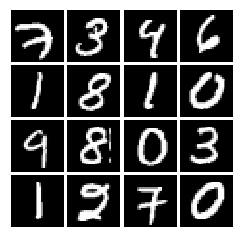

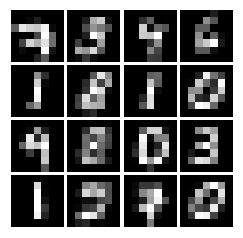

In [25]:
def pool(X, pool_size=4, pool_type="max"):
    # stride == pool_size and pool_size should divide L
    stride = pool_size
    N, D = np.shape(X)
    L = int(np.ceil(np.sqrt(D)))
    X_imgs = X.reshape(N, L, L)
    L1 = int(L/pool_size)
    X1 = np.zeros((N, L1, L1))
    for i in range(L1):
        for j in range(L1):
            if pool_type == "max":
                X1[:,i,j] = np.max(X_imgs[:,i*stride:i*stride+pool_size, j*stride:j*stride+pool_size], axis=(1,2))
            elif pool_type == "avg":
                X1[:,i,j] = np.mean(X_imgs[:,i*stride:i*stride+pool_size, j*stride:j*stride+pool_size], axis=(1,2))
            elif pool_type == "median":
                X1[:,i,j] = np.median(X_imgs[:,i*stride:i*stride+pool_size, j*stride:j*stride+pool_size], axis=(1,2))
    return np.reshape(X1, (N,-1))

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./datasets/MNIST_data', one_hot=False)
X_train = pool(mnist.train.images, 4, "avg")
y_train = mnist.train.labels
X_test = pool(mnist.test.images, 4, "avg")
y_test = mnist.test.labels

N, D = np.shape(X_train)

print(D)

# show a batch
show_images(mnist.train.images[0:16])
show_images(X_train[0:16])

In [4]:
# clear old variables
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, D])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

def softmax_regression_model(X):
    W = tf.Variable(tf.zeros([D, 10]), name="weights")
    b = tf.Variable(tf.zeros([10]), name="biases")
    y_out = tf.matmul(X, W) + b
    return y_out

y_out = softmax_regression_model(X)

mean_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(y,10), logits=y_out))
train_step = tf.train.AdamOptimizer().minimize(mean_loss)

In [5]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

Training
Iteration 0: with minibatch training loss = 2.3 and accuracy of 0.12
Iteration 100: with minibatch training loss = 2.1 and accuracy of 0.67
Iteration 200: with minibatch training loss = 2 and accuracy of 0.62
Iteration 300: with minibatch training loss = 1.76 and accuracy of 0.73
Iteration 400: with minibatch training loss = 1.64 and accuracy of 0.75
Iteration 500: with minibatch training loss = 1.58 and accuracy of 0.75
Iteration 600: with minibatch training loss = 1.57 and accuracy of 0.73
Iteration 700: with minibatch training loss = 1.51 and accuracy of 0.73
Iteration 800: with minibatch training loss = 1.4 and accuracy of 0.73
Epoch 1, Overall loss = 1.71 and accuracy of 0.704


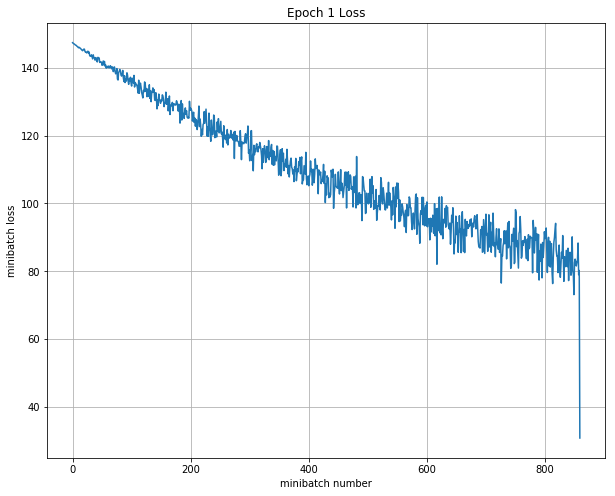

Iteration 900: with minibatch training loss = 1.37 and accuracy of 0.73
Iteration 1000: with minibatch training loss = 1.14 and accuracy of 0.86
Iteration 1100: with minibatch training loss = 1.26 and accuracy of 0.8
Iteration 1200: with minibatch training loss = 1.04 and accuracy of 0.78
Iteration 1300: with minibatch training loss = 1.1 and accuracy of 0.8
Iteration 1400: with minibatch training loss = 0.946 and accuracy of 0.81
Iteration 1500: with minibatch training loss = 0.876 and accuracy of 0.88
Iteration 1600: with minibatch training loss = 0.937 and accuracy of 0.81
Iteration 1700: with minibatch training loss = 0.835 and accuracy of 0.83
Epoch 2, Overall loss = 1.09 and accuracy of 0.795


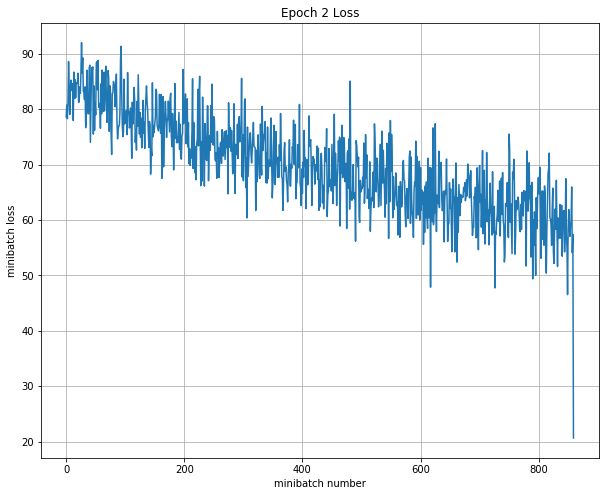

Test
Epoch 1, Overall loss = 0.912 and accuracy of 0.824


In [6]:
sess = tf.Session()
with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
    sess.run(tf.global_variables_initializer())
    print('Training')
    run_model(sess,y_out,mean_loss,X_train,y_train,2,64,100,train_step,True)
    print('Test')
    run_model(sess,y_out,mean_loss,X_test,y_test,1,64)

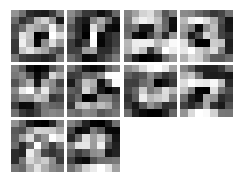

In [7]:
weights = [v for v in tf.trainable_variables() if v.name == "weights:0"][0]
weights_nd = weights.eval(sess).T
weight_min = np.min(weights_nd, axis=1).reshape(10,1)
weigth_max = np.max(weights_nd, axis=1).reshape(10,1)
weights_normalized = (weights_nd - weight_min)/(weigth_max - weight_min + 1e-6)
show_images(weights_normalized)

(1, 49)


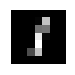

In [8]:
ones_index = (y_test == 1).nonzero()[0]
print(np.shape(X_test[ones_index[0]].reshape(1,D)))
show_images(X_test[ones_index[0]].reshape(1,D))
one_img = X_test[ones_index[0]].reshape(1,D)

In [51]:
def get_probability(scores, target_y):
    e_s = np.exp(scores)
    e_s_sum = np.sum(e_s)
    return e_s[0,target_y]/e_s_sum

def normalize(a):
    a_min = np.min(a)
    a_max = np.max(a)
    return (a-a_min)/(a_max - a_min + 1e-8)

def make_fooling_image(X_img, target_y, num_iters=100, learning_rate=1, print_every=10):
    fimagesL = []
    X_fooling = X_img.copy()
    grads = tf.gradients(mean_loss, X)
    for i in range(num_iters):
        fimagesL.append(X_fooling.copy())
        s = sess.run(y_out, {X: X_fooling})
        prob_target_y = get_probability(s, target_y)
        if s[0].argmax() == target_y and prob_target_y > 0.9999:
            print("Iteration ", i)
            print("Probability of ", target_y, " is ", prob_target_y)
            break
            
        g = sess.run(grads, {X: X_fooling, y: np.array([target_y])})
        dX = learning_rate * g[0] / tf.norm(g[0])
        dX_val = -1 * dX.eval(session=sess)
        
        if print_every and i % print_every == 0:
            show_images(X_fooling)
            #show_images(dX_val)
            print("Probability of ", target_y, " is ", prob_target_y)
        X_fooling += dX_val
    return X_fooling, fimagesL

Iteration  24
Probability of  2  is  0.999936


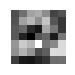

In [22]:
one_fooling_img, fimagesL = make_fooling_image(X_img=one_img, target_y=2, num_iters=100, learning_rate=0.1, print_every=None)
show_images(one_fooling_img)

Probability of  5  is  0.0541721
Probability of  5  is  0.823807
Probability of  5  is  0.994833
Probability of  5  is  0.999855
Iteration  32
Probability of  5  is  0.999929


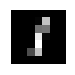

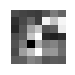

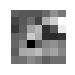

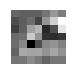

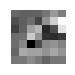

In [23]:
one_fooling_img, fimagesL = make_fooling_image(X_img=one_img, target_y=5, num_iters=100, learning_rate=0.1, print_every=10)
show_images(one_fooling_img)

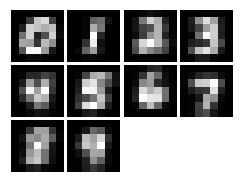

In [19]:
avg_images = np.zeros((10,49))
for i in range(10):
    indices = (y_train == i).nonzero()[0]
    avg_images[i] = np.mean(X_train[indices], axis=0)
    #print(np.shape(X_train[indices]))
    #show_images(mnist.train.images[indices][0:4])
show_images(avg_images)

In [ ]:
num_digits = 4
m = int((num_digits)*(num_digits-1)/2)
fimages = np.zeros((m,10,49))
count = 0
for i in range(num_digits):
    for j in range(num_digits):
        if i == j :
            continue
        indices = (y_test == i).nonzero()[0]
        digit_img = X_test[indices[0]].reshape(1,D)
        fooling_img, fimagesL = make_fooling_image(X_img=digit_img, target_y=j, num_iters=100, learning_rate=0.1, print_every=None)
        step_size = len(fimagesL)/10
        for c in range(10):
            ind = int(step_size*c)
            fimages[count, c] = fimagesL[ind][0]
            #show_images(fimagesL[ind])
        count+=1

(4, 10, 49)


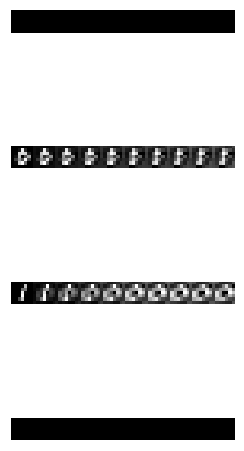

In [58]:
print(np.shape(fimages))
show_images_mxn(fimages, m, 10)